In [1]:
import kan
import kan.utils as ku
import numpy as np
import torch.nn as nn
import torch
import qutip as qt
import matplotlib.pyplot as plt
from libraries import utils
from libraries import magnetization
from libraries import j1j2_functions

In [2]:
N=12; J1=1
J2s = np.linspace(0, 0.5 - 0.5/100, 100)
print(J2s[-1])
gss = [qt.qload(f'../J1J2_info/N{N}/n{N}gs_J2_{round(J2, 3)}') for J2 in J2s]
states = utils.get_nonzero_states(N, gss[0], 1e-10)[0]
signs = [utils.get_nonzero_states(N, gs, 1e-10)[1] for gs in gss]

0.495


In [3]:
nd = 0b010101010101 # this never deviates, let this be of negative sign cos(pi/4 * amplitude)
index = states.index(nd)
print(nd)
for i in range(len(signs)):
    if signs[i][index] > 0:
        signs[i] = -1 * np.array(signs[i])
    else:
        signs[i] = np.array(signs[i])

1365


In [4]:
def rfft(x):
    x = (-1) ** np.array(x)
    return np.fft.rfft(x)[1:]

input = utils.generate_input_samples(N, states)
print(input.shape)
ft_input = []
for x in input:
    amp_phase = []
    ft = rfft(x)
    for c in ft:
        amp_phase.append(np.abs(c))
        amp_phase.append(np.angle(c) % (2 * np.pi))
    ft_input.append(amp_phase)
ft_input = torch.tensor(ft_input)

torch.Size([924, 12])


C:\Users\taoha\AppData\Local\Temp\ipykernel_22520\2939947991.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  x = (-1) ** np.array(x)


In [5]:
msr_vec = torch.tensor([0] * (N - 2) + [np.pi / 4, 0]).reshape(-1, 1)

In [6]:
def train(model, epochs, datarate, phase_num=0, lr=1, lamb=0, reg_metric='edge_forward_spline_n', lamb_l1=1., lamb_entropy=2., lamb_coef=0., lamb_coefdiff=0.):
    opt = torch.optim.LBFGS(model.parameters(), lr = lr)
    for i in range(epochs):
        def closure():
            opt.zero_grad()
            pred = torch.cos(ft_input @ msr_vec + model(ft_input))
            loss = torch.mean((pred - torch.tensor(signs[phase_num].reshape(-1, 1))) ** 2) + lamb * model.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
            loss.backward()
            return loss
        loss = opt.step(closure)
        if i % datarate == 0:
            print(loss.item())
    print(loss.item())

checkpoint directory created: ./model
saving model version 0.0


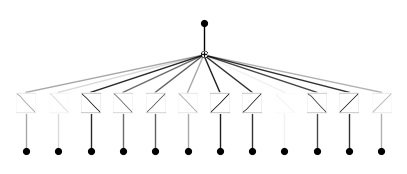

In [42]:
k0_lin = kan.KAN(width=[N, 1])
k0_lin(ft_input)
k0_lin.plot()

In [ ]:
k0_lin = kan.KAN(width=[N, 1])
k0_lin(ft_input)
for i in range(1, N, 2):
    k0_lin.fix_symbolic(0, i, 0, '0', verbose=False, log_history=False)
#for i in range(0, N, 1):
#    k0_lin.fix_symbolic(0, i, 0, 'x', verbose=False, log_history=False);
# train(k0_lin, 50, 5, phase_num=0, lamb=1e-3, lr=0.1)

checkpoint directory created: ./model
saving model version 0.0
0.5602483153343201
2.253390221085283e-06
2.08201313967038e-08
1.872878385711374e-08
1.779035407878382e-08
1.7567378662874944e-08
1.7567378662874944e-08
1.7567378662874944e-08
1.7567378662874944e-08
1.7567378662874944e-08
1.7567378662874944e-08


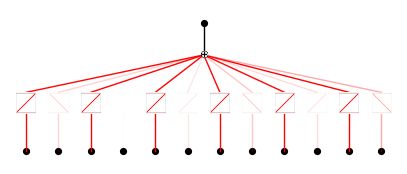

In [39]:
k0_lin.plot()

In [40]:
ku.ex_round(k0_lin.symbolic_formula()[0][0], 3)

0.006*x_1 + 0.005*x_11 - 0.e-3*x_12 + 0.006*x_3 + 0.007*x_5 + 0.005*x_7 + 0.005*x_9 - 0.1

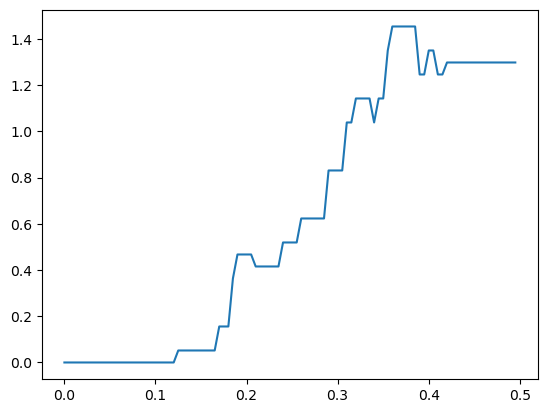

In [19]:
pred = torch.cos(ft_input @ msr_vec + k0_lin(ft_input)) # this is just MSR rn
errs = []
for i in range(len(J2s)):
    errs.append(torch.mean((pred - torch.tensor(signs[i].reshape(-1, 1))) ** 2).item())
plt.plot(J2s, errs)
plt.show() # okay so this is just the exact shape of number of deviating strings

In [20]:
train(k0_lin, 50, 5, phase_num=30, lamb=0, lr=0.1)

0.05193044990301132
0.026350300759077072
0.020925117656588554
0.020925089716911316
0.020925089716911316
0.020925089716911316
0.020925089716911316
0.020925089716911316
0.020925089716911316
0.020925089716911316
0.020925089716911316


In [21]:
0.020997 * 924 / 4 # 5 mistakes out of 12

4.850307

In [26]:
torch.mean((torch.sgn(torch.cos(ft_input @ msr_vec + k0_lin(ft_input))) - torch.tensor(signs[30].reshape(-1, 1))) ** 2) * 924/4

tensor(1., grad_fn=<DivBackward0>)

In [27]:
len(utils.find_sign_deviations(states, signs[30], signs[0]))

12

In [28]:
ku.ex_round(k0_lin.symbolic_formula()[0][0], 2)

-0.06*x_1 - 0.e-2*x_10 + 0.08*x_11 - 0.e-2*x_2 + 0.15*x_3 - 0.e-2*x_4 + 0.12*x_5 - 0.03*x_6 + 0.14*x_7 + 0.01*x_8 + 0.18*x_9 - 1.79

In [ ]:
torch.mean((torch.sgn(torch.cos(ft_input @ msr_vec + k0_lin(ft_input))) - torch.tensor(signs[40].reshape(-1, 1))) ** 2) * 924/4
# 97 mistakes when training on 

tensor(97., grad_fn=<DivBackward0>)

In [14]:
train(k0_lin, 50, 5, phase_num=40, lamb=1e-3, lr=0.1)

0.36763355135917664
0.13672015070915222
0.12445490807294846
0.1244548112154007
0.1244548112154007
0.1244548112154007
0.1244548112154007
0.1244548112154007
0.1244548112154007
0.1244548112154007
0.1244548112154007


In [15]:
ku.ex_round(k0_lin.symbolic_formula()[0][0], 2)

-0.43*x_1 + 0.03*x_11 - 0.e-2*x_3 + 0.05*x_5 + 0.06*x_7 + 0.18*x_9 + 0.03

28.7364